In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

In [8]:
df = pd.read_csv(r'D:\My PhD\Summer 2024\I_GUIDE\Data\Weather_data_for_ET0_Estimation\Daily_AWS_data.csv')

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df

,date,DOY,Tmax,Tmin,Rhmax,Rhmin,Solar Radiation,U
0,2018-01-01,1,-1.060,-18.730,96.8,44.5,10.050,3.35
1,2018-01-02,2,3.100,-18.600,88.8,21.4,10.390,4.07
2,2018-01-03,3,9.800,-8.510,74.7,21.7,10.260,2.74
3,2018-01-04,4,10.610,-6.630,94.6,27.3,10.190,3.24
4,2018-01-05,5,10.340,-7.430,95.9,23.4,5.990,2.72
...,...,...,...,...,...,...,...,...
2186,2023-12-27,361,4.055,-6.554,95.5,45.3,5.762,6.57
2187,2023-12-28,362,4.524,-10.040,82.3,37.3,8.890,3.42
2188,2023-12-29,363,8.150,-8.090,76.7,35.0,8.690,3.31
2189,2023-12-30,364,10.890,-7.960,91.1,29.3,8.740,2.85


In [11]:
# Constants
latitude = 40.1548
longitude = -103.1420
elevation = 1382.878
Gsc = 0.0820  # Solar constant [MJ m-2 min-1]
sigma = 4.903e-9  # Stefan-Boltzmann constant [MJ K-4 m-2 day-1]

# Calculate additional parameters
df['Tmean'] = (df['Tmax'] + df['Tmin']) / 2.0
df['eo_Tmin'] = 0.6108 * np.exp((17.27 * df['Tmin']) / (df['Tmin'] + 237.3))
df['eo_Tmax'] = 0.6108 * np.exp((17.27 * df['Tmax']) / (df['Tmax'] + 237.3))
df['es'] = (df['eo_Tmax'] + df['eo_Tmin']) / 2
df['ea'] = (df['eo_Tmin'] * df['Rhmax'] / 100 + df['eo_Tmax'] * df['Rhmin'] / 100) / 2
df['delta'] = 4098 * ((0.6108 * np.exp((17.27 * df['Tmean']) / (df['Tmean'] + 237.3)))) / ((df['Tmean'] + 237.3) ** 2)
df['gamma'] = 0.665e-3 * (101.3 * ((293 - 0.0065 * elevation) / 293) ** 5.26)

# Calculate solar radiation
df['dr'] = 1 + 0.033 * np.cos(2 * np.pi / 365 * df['DOY'])
df['delta_r'] = 0.409 * np.sin(2 * np.pi / 365 * df['DOY'] - 1.39)
df['omega'] = np.arccos(-np.tan(np.radians(latitude)) * np.tan(df['delta_r']))
df['Ra'] = (24 * 60 / np.pi) * Gsc * df['dr'] * (
        df['omega'] * np.sin(np.radians(latitude)) * np.sin(df['delta_r']) + np.cos(np.radians(latitude)) * np.cos(
    df['delta_r']) * np.sin(df['omega']))

# Calculate clear-sky radiation
df['Rso'] = (0.75 + 2e-5 * elevation) * df['Ra']

# Calculate net radiation
df['Rns'] = (1 - 0.23) * df['Solar Radiation']
df['Rnl'] = sigma * (
        (df['Tmax'] + 273.16) ** 4 + (df['Tmin'] + 273.16) ** 4) / 2 * (0.34 - 0.14 * np.sqrt(df['ea'])) * (
                          1.35 * df['Solar Radiation'] / df['Rso'] - 0.35)
df['Rn'] = df['Rns'] - df['Rnl']

# Assuming soil heat flux density (G) is zero
G = 0

# Calculate ET0 using Penman-Monteith equation
df['ET0'] = (0.408 * df['delta'] * (df['Rn'] - G) + df['gamma'] * (900 / (df['Tmean'] + 273)) * df['U'] * (df['es'] - df['ea'])) / (df['delta'] + df['gamma'] * (1 + 0.34 * df['U']))

In [12]:
df

,date,DOY,Tmax,Tmin,Rhmax,Rhmin,Solar Radiation,U,Tmean,eo_Tmin,...,gamma,dr,delta_r,omega,Ra,Rso,Rns,Rnl,Rn,ET0
0,2018-01-01,1,-1.060,-18.730,96.8,44.5,10.050,3.35,-9.8950,0.139052,...,0.057181,1.032995,-0.401008,1.204972,13.736578,10.682354,7.73850,6.075591,1.662909,0.824923
1,2018-01-02,2,3.100,-18.600,88.8,21.4,10.390,4.07,-7.7500,0.140610,...,0.057181,1.032980,-0.399564,1.206510,13.792140,10.725562,8.00030,6.751333,1.248967,1.575711
2,2018-01-03,3,9.800,-8.510,74.7,21.7,10.260,2.74,0.6450,0.321308,...,0.057181,1.032956,-0.398001,1.208171,13.852176,10.772249,7.90020,7.004061,0.896139,1.800686
3,2018-01-04,4,10.610,-6.630,94.6,27.3,10.190,3.24,1.9900,0.371812,...,0.057181,1.032922,-0.396320,1.209954,13.916673,10.822406,7.84630,6.694835,1.151465,1.826755
4,2018-01-05,5,10.340,-7.430,95.9,23.4,5.990,2.72,1.4550,0.349519,...,0.057181,1.032878,-0.394522,1.211857,13.985619,10.876023,4.61230,2.887203,1.725097,1.784000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2023-12-27,361,4.055,-6.554,95.5,45.3,5.762,6.57,-1.2495,0.373994,...,0.057181,1.032922,-0.406440,1.199161,13.526205,10.518755,4.43674,2.674365,1.762375,1.406604
2187,2023-12-28,362,4.524,-10.040,82.3,37.3,8.890,3.42,-2.7580,0.284806,...,0.057181,1.032956,-0.405594,1.200070,13.559261,10.544462,6.84530,5.532770,1.312530,1.297040
2188,2023-12-29,363,8.150,-8.090,76.7,35.0,8.690,3.31,0.0300,0.332029,...,0.057181,1.032980,-0.404627,1.201106,13.596833,10.573680,6.69130,5.446030,1.245270,1.604842
2189,2023-12-30,364,10.890,-7.960,91.1,29.3,8.740,2.85,1.4650,0.335411,...,0.057181,1.032995,-0.403540,1.202268,13.638915,10.606405,6.72980,5.523069,1.206731,1.723500


In [13]:
df.to_csv(r'D:\My PhD\Summer 2024\I_GUIDE\Results\ETo_from_Penman.csv')

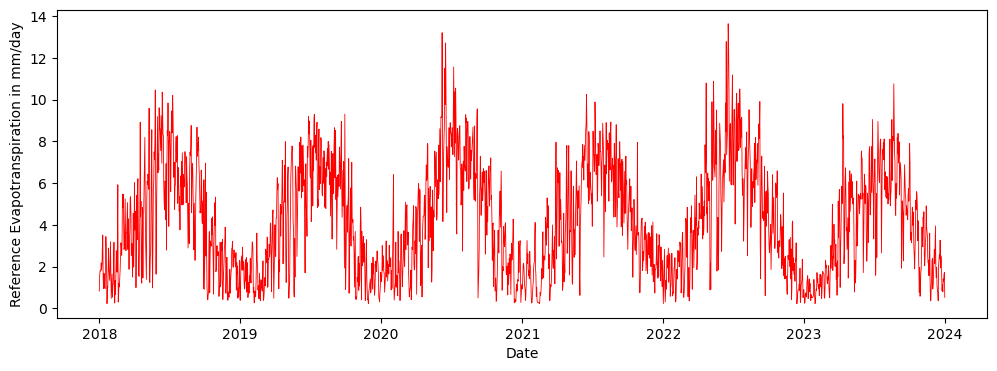

In [15]:
plt.figure(figsize = (12, 4))
plt.plot(df['date'], df['ET0'], linewidth = 0.6, color = 'r')
plt.xlabel('Date')
plt.ylabel('Reference Evapotranspiration in mm/day')
plt.savefig(r'D:\My PhD\Summer 2024\I_GUIDE\Results\Graphs\Time_Series_of_ETo.jpeg', dpi=500, bbox_inches='tight')